#### Installing required packages

In [2]:
!pip install rasterio --quiet
!pip install ultralytics --quiet
!pip install labelme2yolo --quiet
!pip install roboflow==1.1.48 --quiet # Installation is required at each kernel restart on google colab
# TODO: create a requirements.txt file with all the packages to install (then understand how to get access to it in google collab)

### Connecting to Roboflow dataset

In [3]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [4]:
rf = roboflow.Roboflow()

In [4]:
project = rf.workspace("stormdamagechallenge").project("hurricanedamagev7-f6aoq")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to hurricanedamagev7-1 in yolov8:: 100%|██████████| 11843/11843 [00:02<00:00, 5460.06it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


NOTE: defining the HOME path constant

In [5]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Import remaining packages

In [6]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Check the version of Ultralytics

In [7]:
ultralytics.checks()

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 37.3/112.6 GB disk)


In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [9]:
!nvidia-smi

Sat Nov 23 16:42:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading Yolov8 model

In [16]:
# Loading the model
model = YOLO('../models/yolov8/yolov8n.pt')
# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 191MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

In [12]:
# Display model information (optional)
model.info()

Model summary: 225 layers, 3,011,628 parameters, 0 gradients, 8.2 GFLOPs


(225, 3011628, 0, 8.197376)

### Training Model

In [10]:
# Resuming model training from last completed epoch
model = YOLO('runs/detect/train/weights/last.pt')

In [13]:
# Train the model on the dataset for 20 epochs
yaml_file = '/content/hurricanedamagev7-1/data.yaml'
model.train(data=yaml_file, batch = -1, device=0, epochs=3, patience = 5, time=0.5, imgsz=512, plots=True)

Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/train/weights/last.pt, data=/content/hurricanedamagev7-1/data.yaml, epochs=3, time=0.5, patience=5, batch=-1, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

train: Scanning /content/hurricanedamagev7-1/train/labels.cache... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=512 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.10G reserved, 0.06G allocated, 14.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     3011628       5.246         0.157         69.27         394.3        (1, 3, 512, 512)                    list
     3011628       10.49         0.226         24.74         48.14        (2, 3, 512, 512)                    list
     3011628       20.99         0.382         25.31         48.23        (4, 3, 512, 512)                    list
     3011628       41.97         0.736         27.43         58.82        (8, 3, 512, 512)                    list
     3011628       83.94         1.

train: Scanning /content/hurricanedamagev7-1/train/labels.cache... 4736 images, 1 backgrounds, 0 corrupt: 100%|██████████| 4736/4736 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/hurricanedamagev7-1/valid/labels.cache... 1181 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1181/1181 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0008203125), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 0.5 hours...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      11.1G     0.8622     0.9374      1.002        161        512: 100%|██████████| 46/46 [01:13<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:16<00:00,  2.70s/it]


                   all       1181      20917       0.58      0.609      0.614      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20        15G     0.8476     0.9035     0.9962        226        512: 100%|██████████| 46/46 [01:11<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.48s/it]

                   all       1181      20917      0.584      0.594      0.612      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      14.1G     0.8676     0.9322      1.007        359        512: 100%|██████████| 46/46 [01:07<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:14<00:00,  2.41s/it]


                   all       1181      20917      0.498      0.583      0.557      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/21      11.2G     0.8802     0.9463      1.012        285        512: 100%|██████████| 46/46 [01:08<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:15<00:00,  2.59s/it]


                   all       1181      20917      0.549       0.59      0.597      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/21      11.6G     0.8814     0.9379      1.011        252        512: 100%|██████████| 46/46 [01:05<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


                   all       1181      20917      0.571      0.617      0.614      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/21      10.8G     0.8751     0.9176      1.004        378        512: 100%|██████████| 46/46 [01:06<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.23s/it]


                   all       1181      20917      0.499      0.603      0.553      0.418
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

6 epochs completed in 0.142 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:39<00:00,  6.59s/it]


                   all       1181      20917      0.578      0.611      0.615      0.472
damagedcommercialbuilding        458        881      0.398      0.512      0.417      0.294
damagedresidentialbuilding        872       3490      0.502      0.677      0.591       0.45
undamagedcommercialbuilding        662       2421      0.552      0.516      0.558      0.428
undamagedresidentialbuilding        892      14125      0.859       0.74      0.892      0.717
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bfc897689a0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

/content


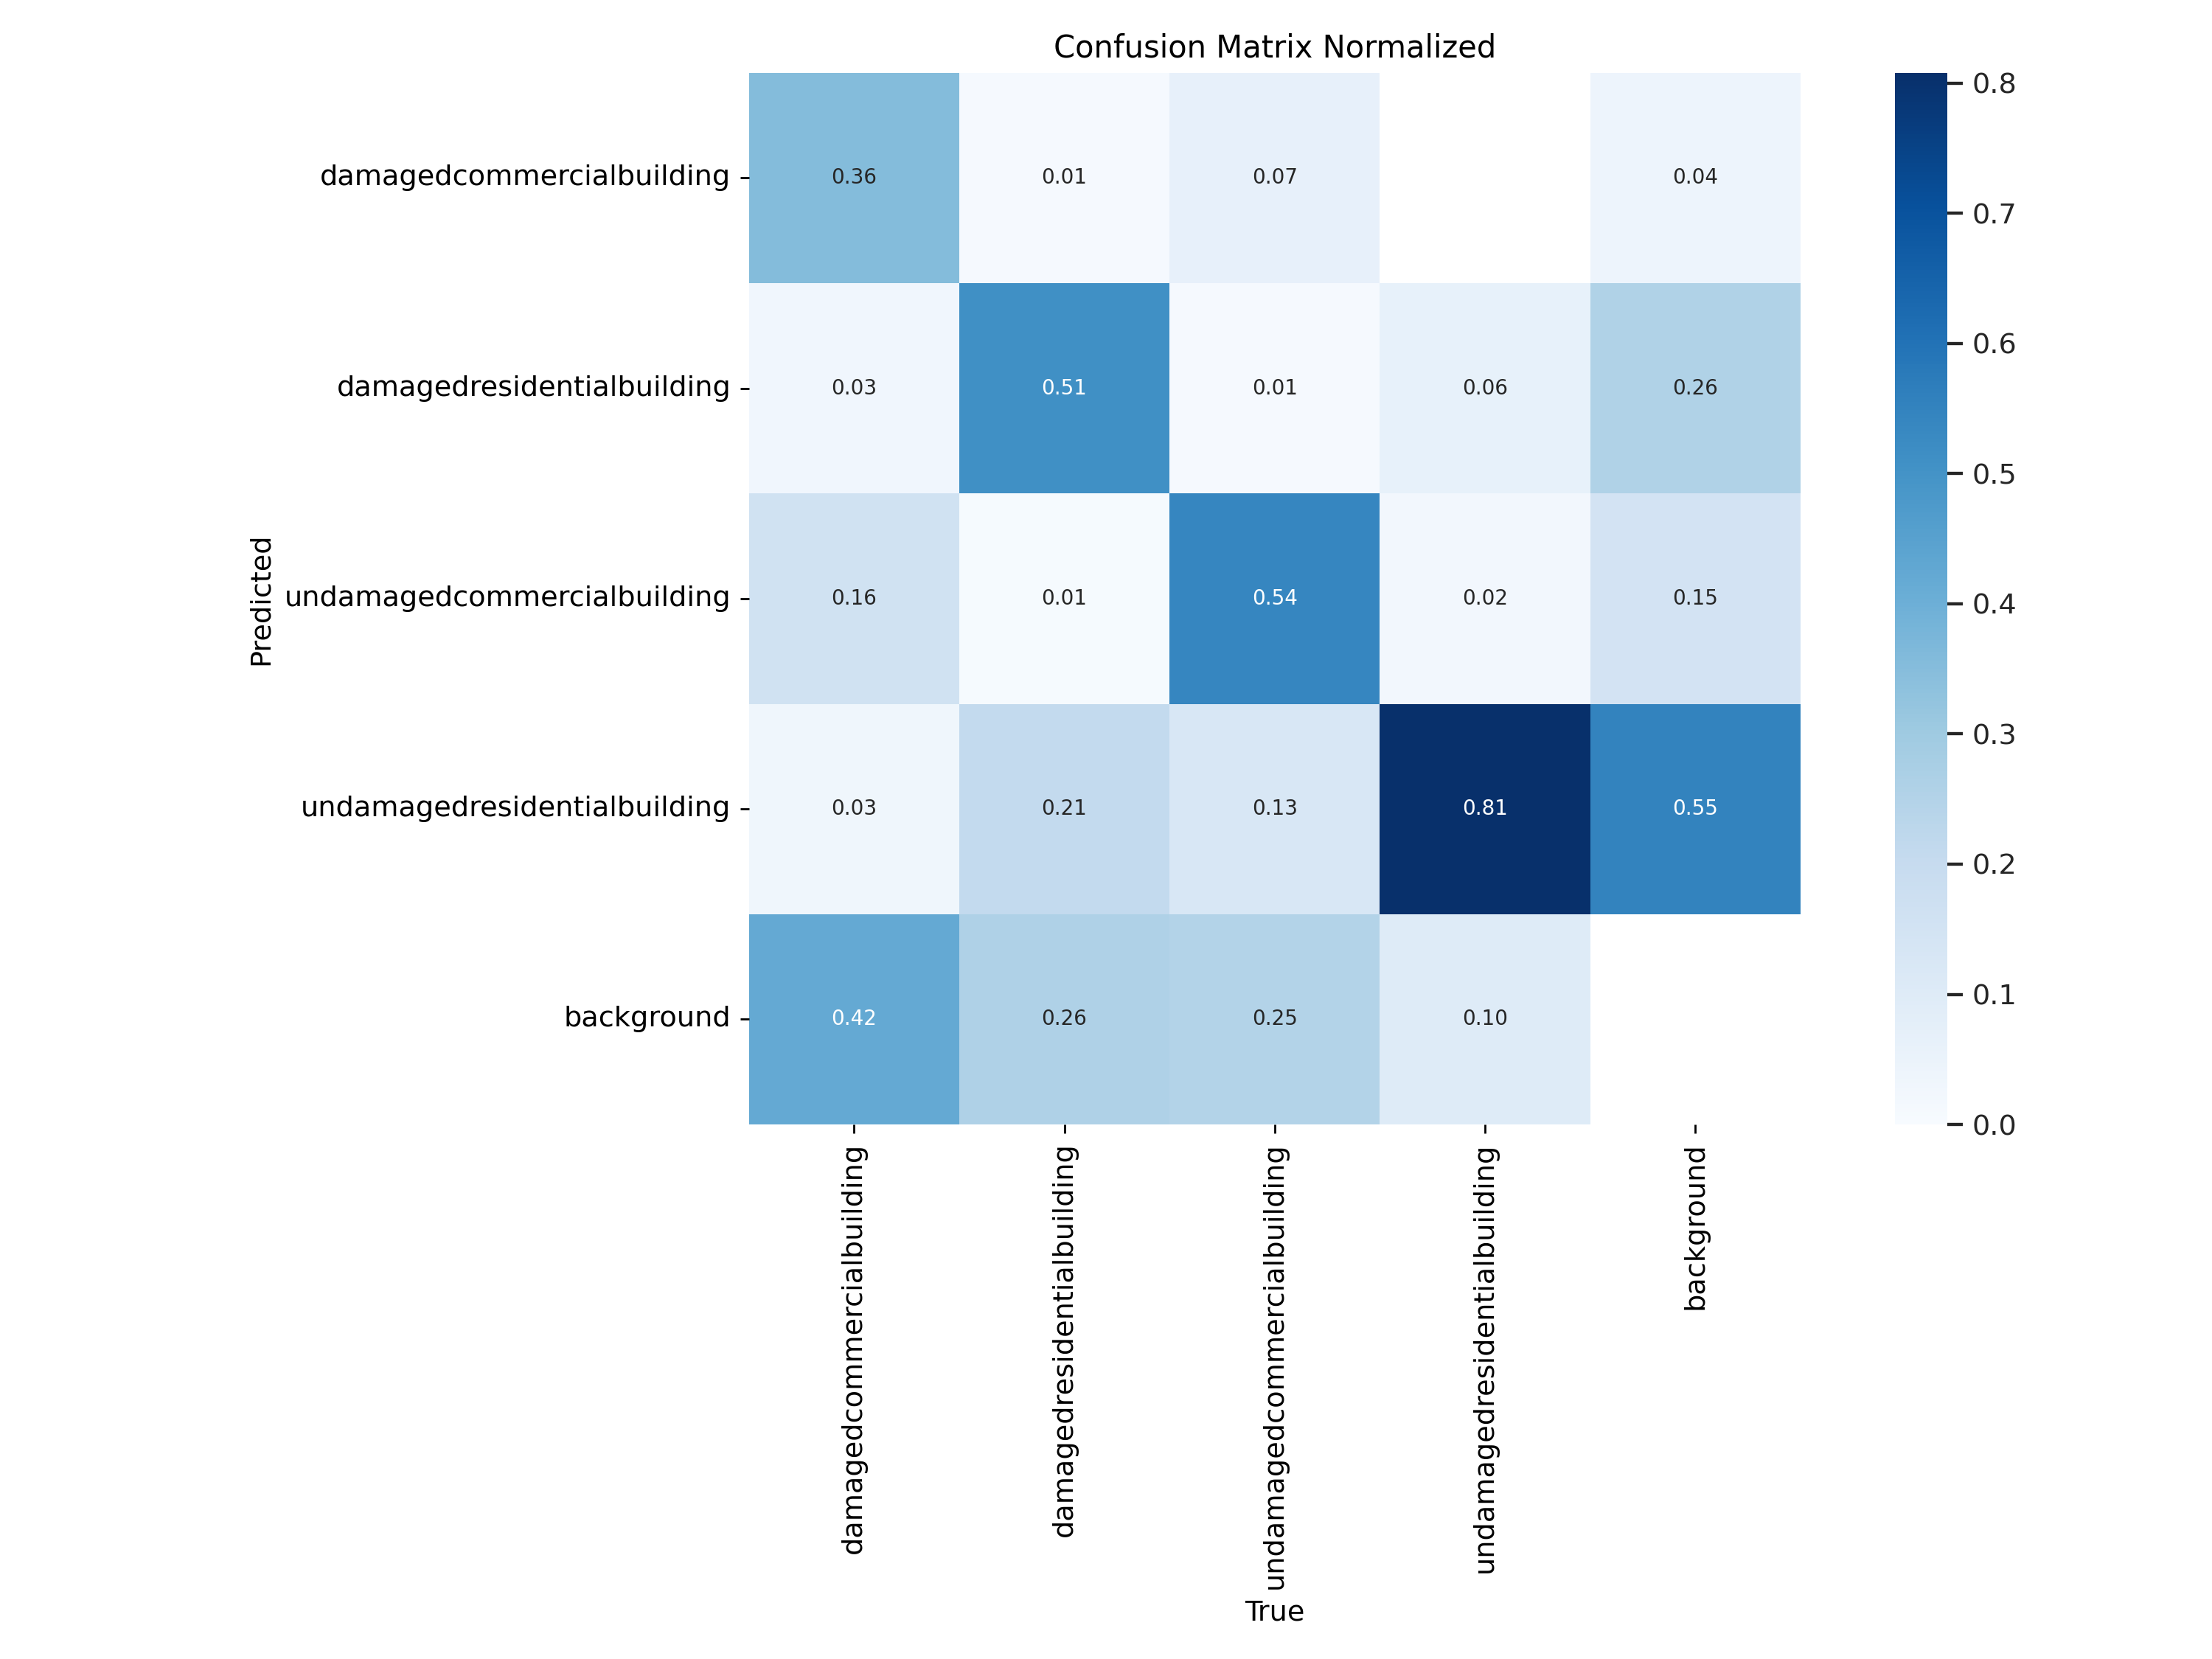

In [22]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png', width=600) # FIRST RUN: 20 epochs

/content


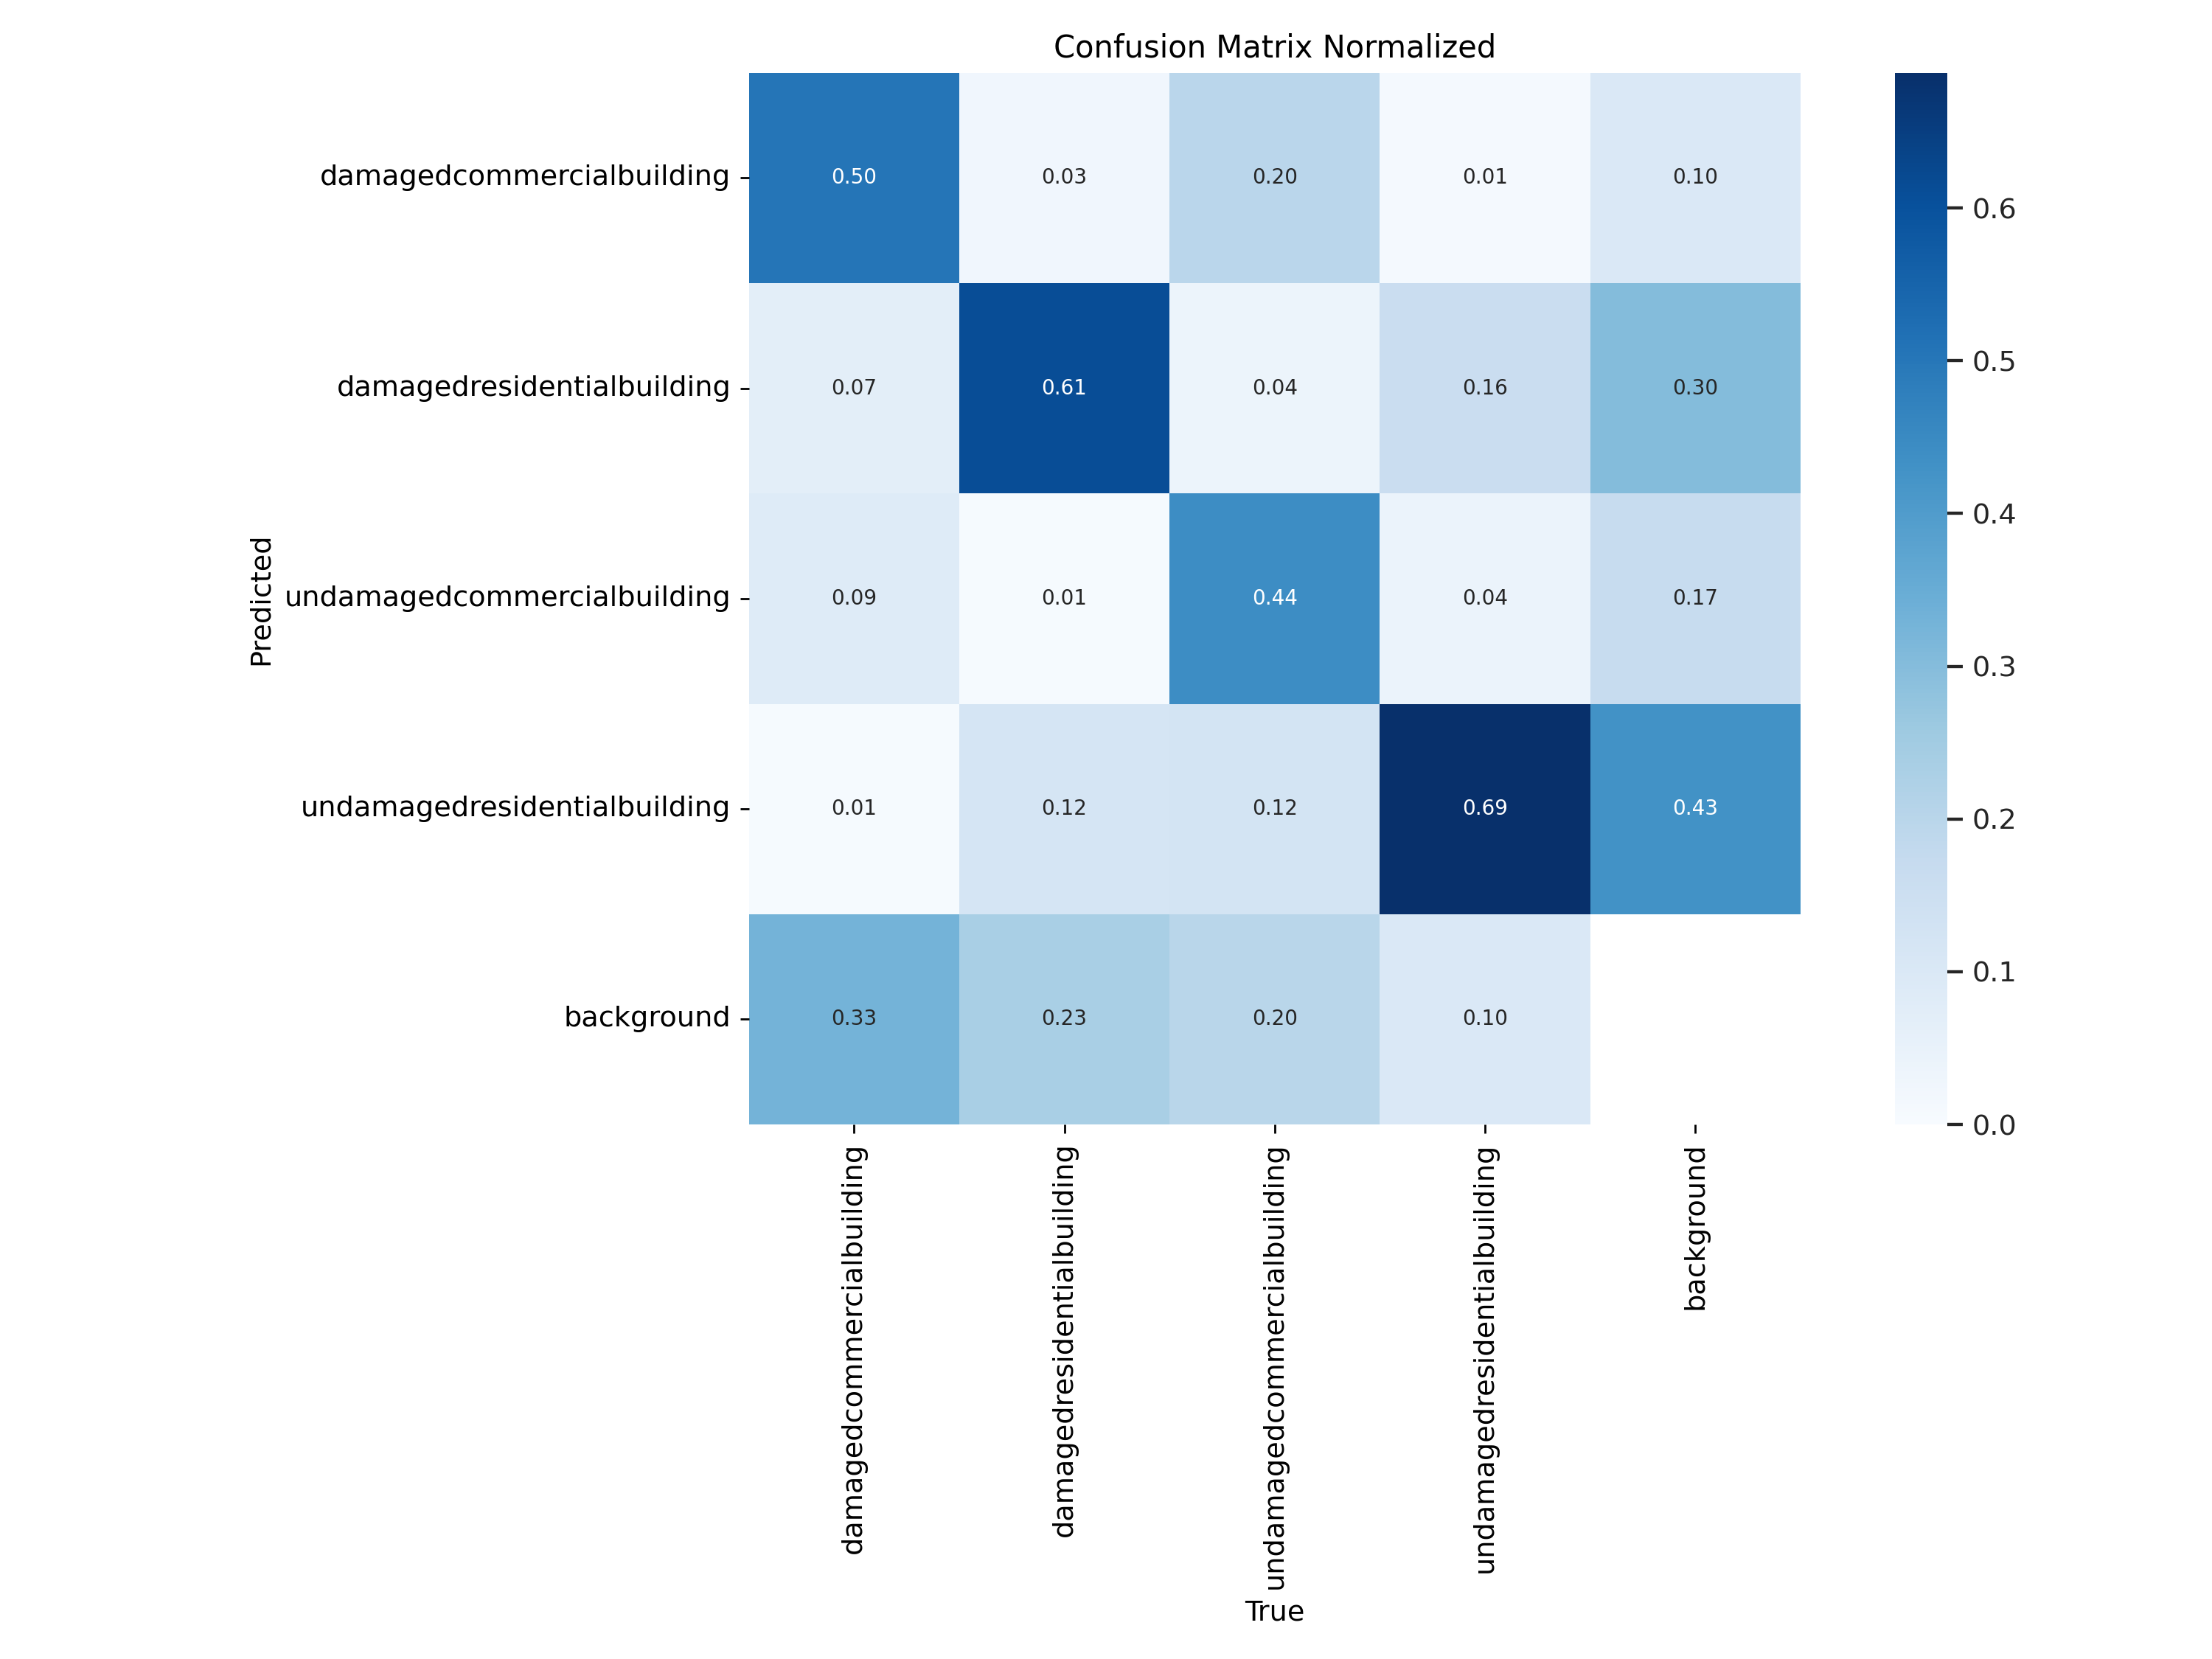

In [14]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/confusion_matrix_normalized.png', width=600) # FIRST RUN: 20 epochs

/content


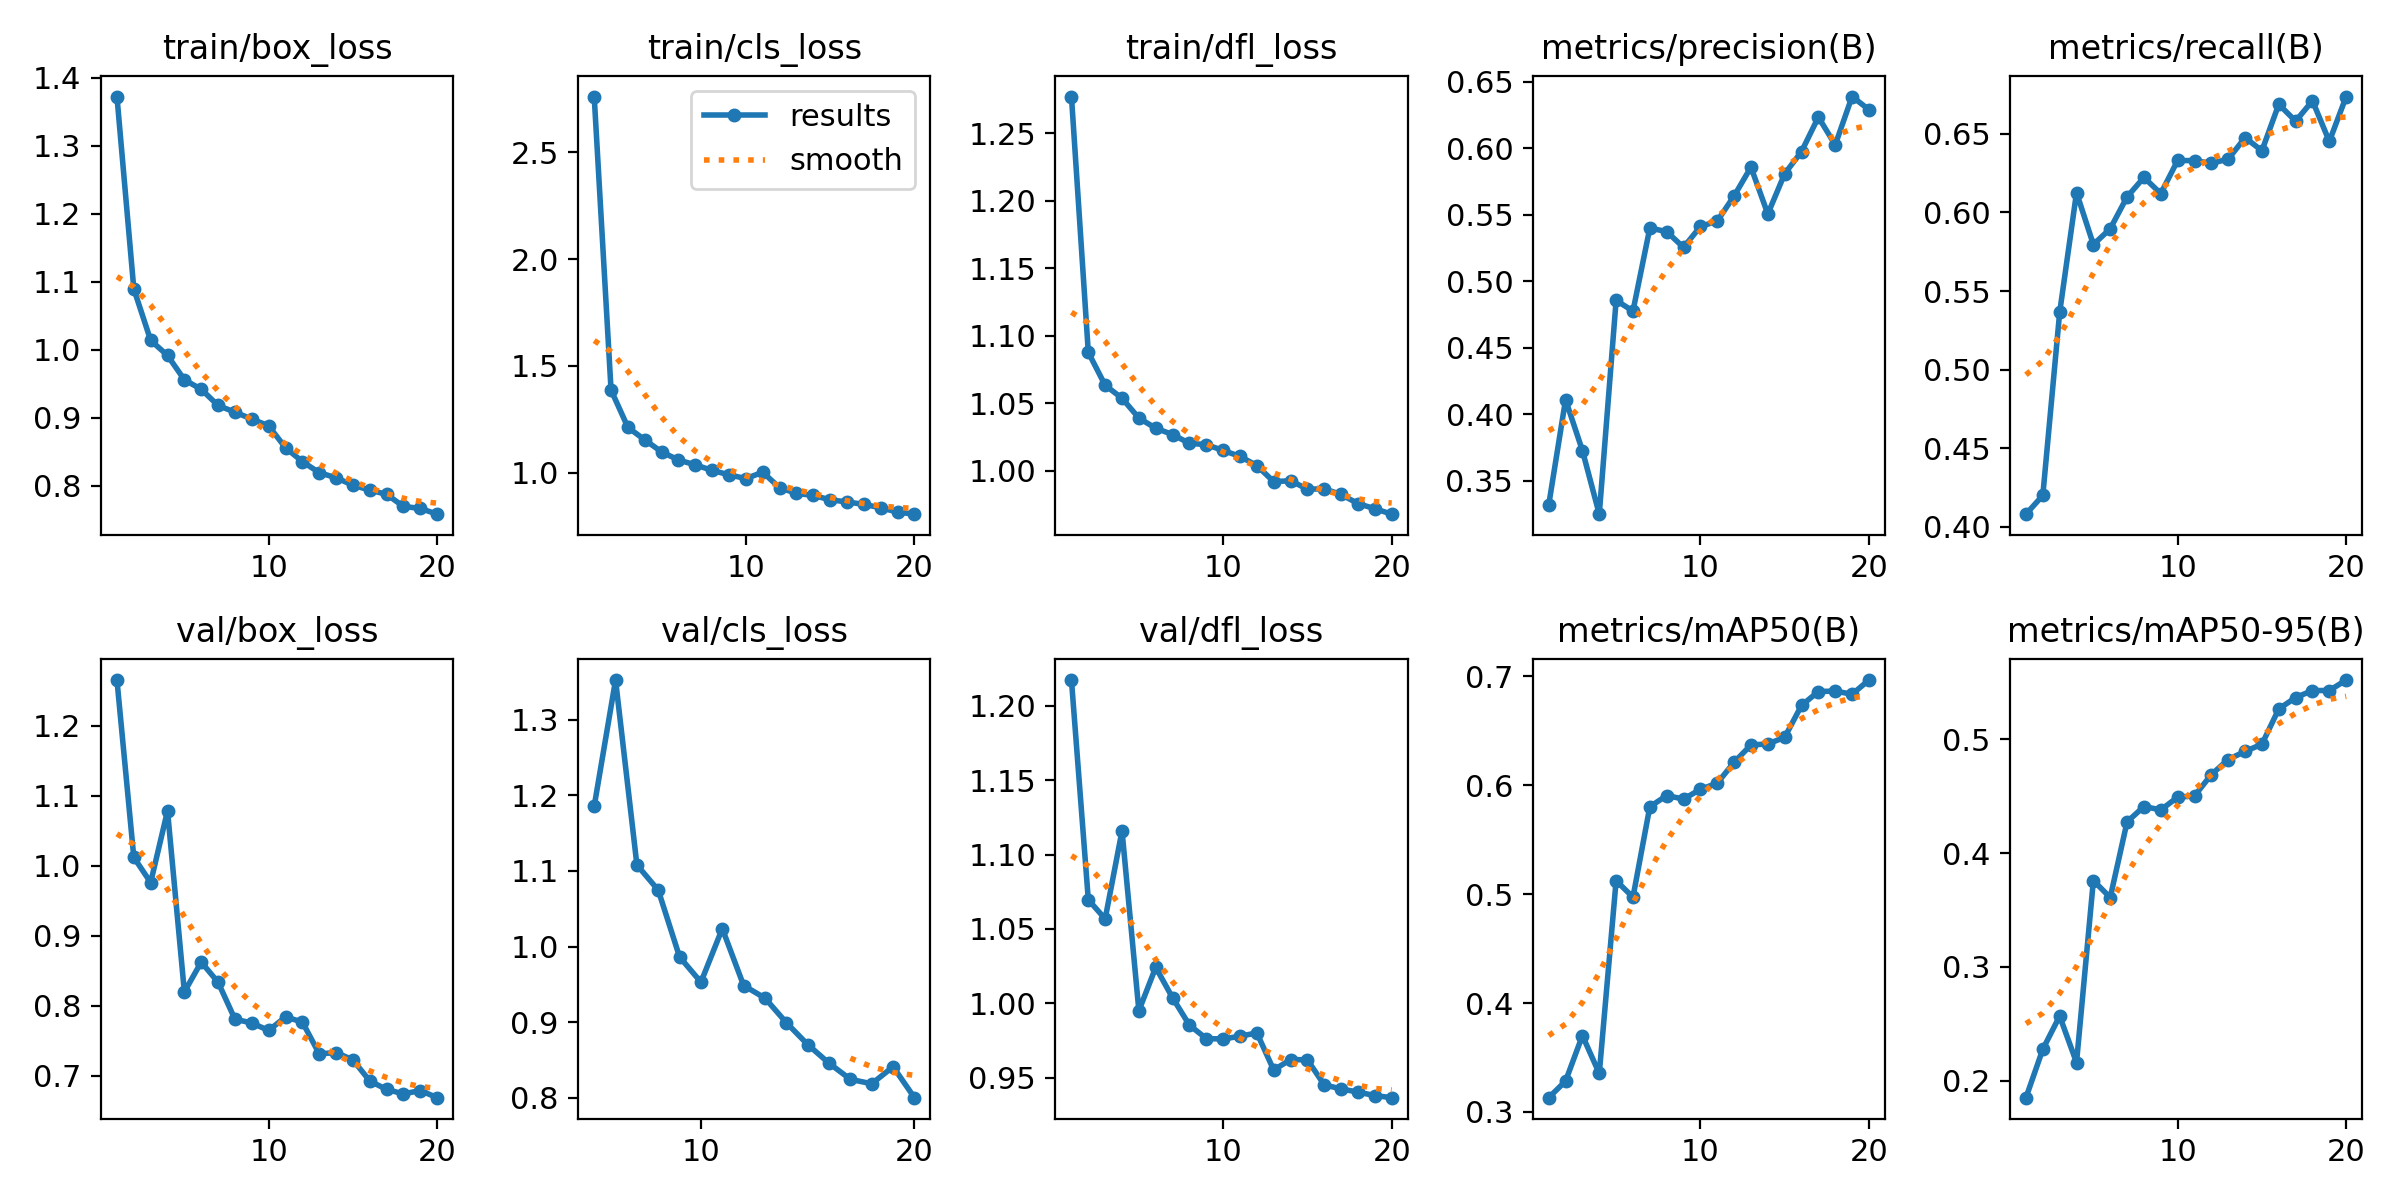

In [23]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


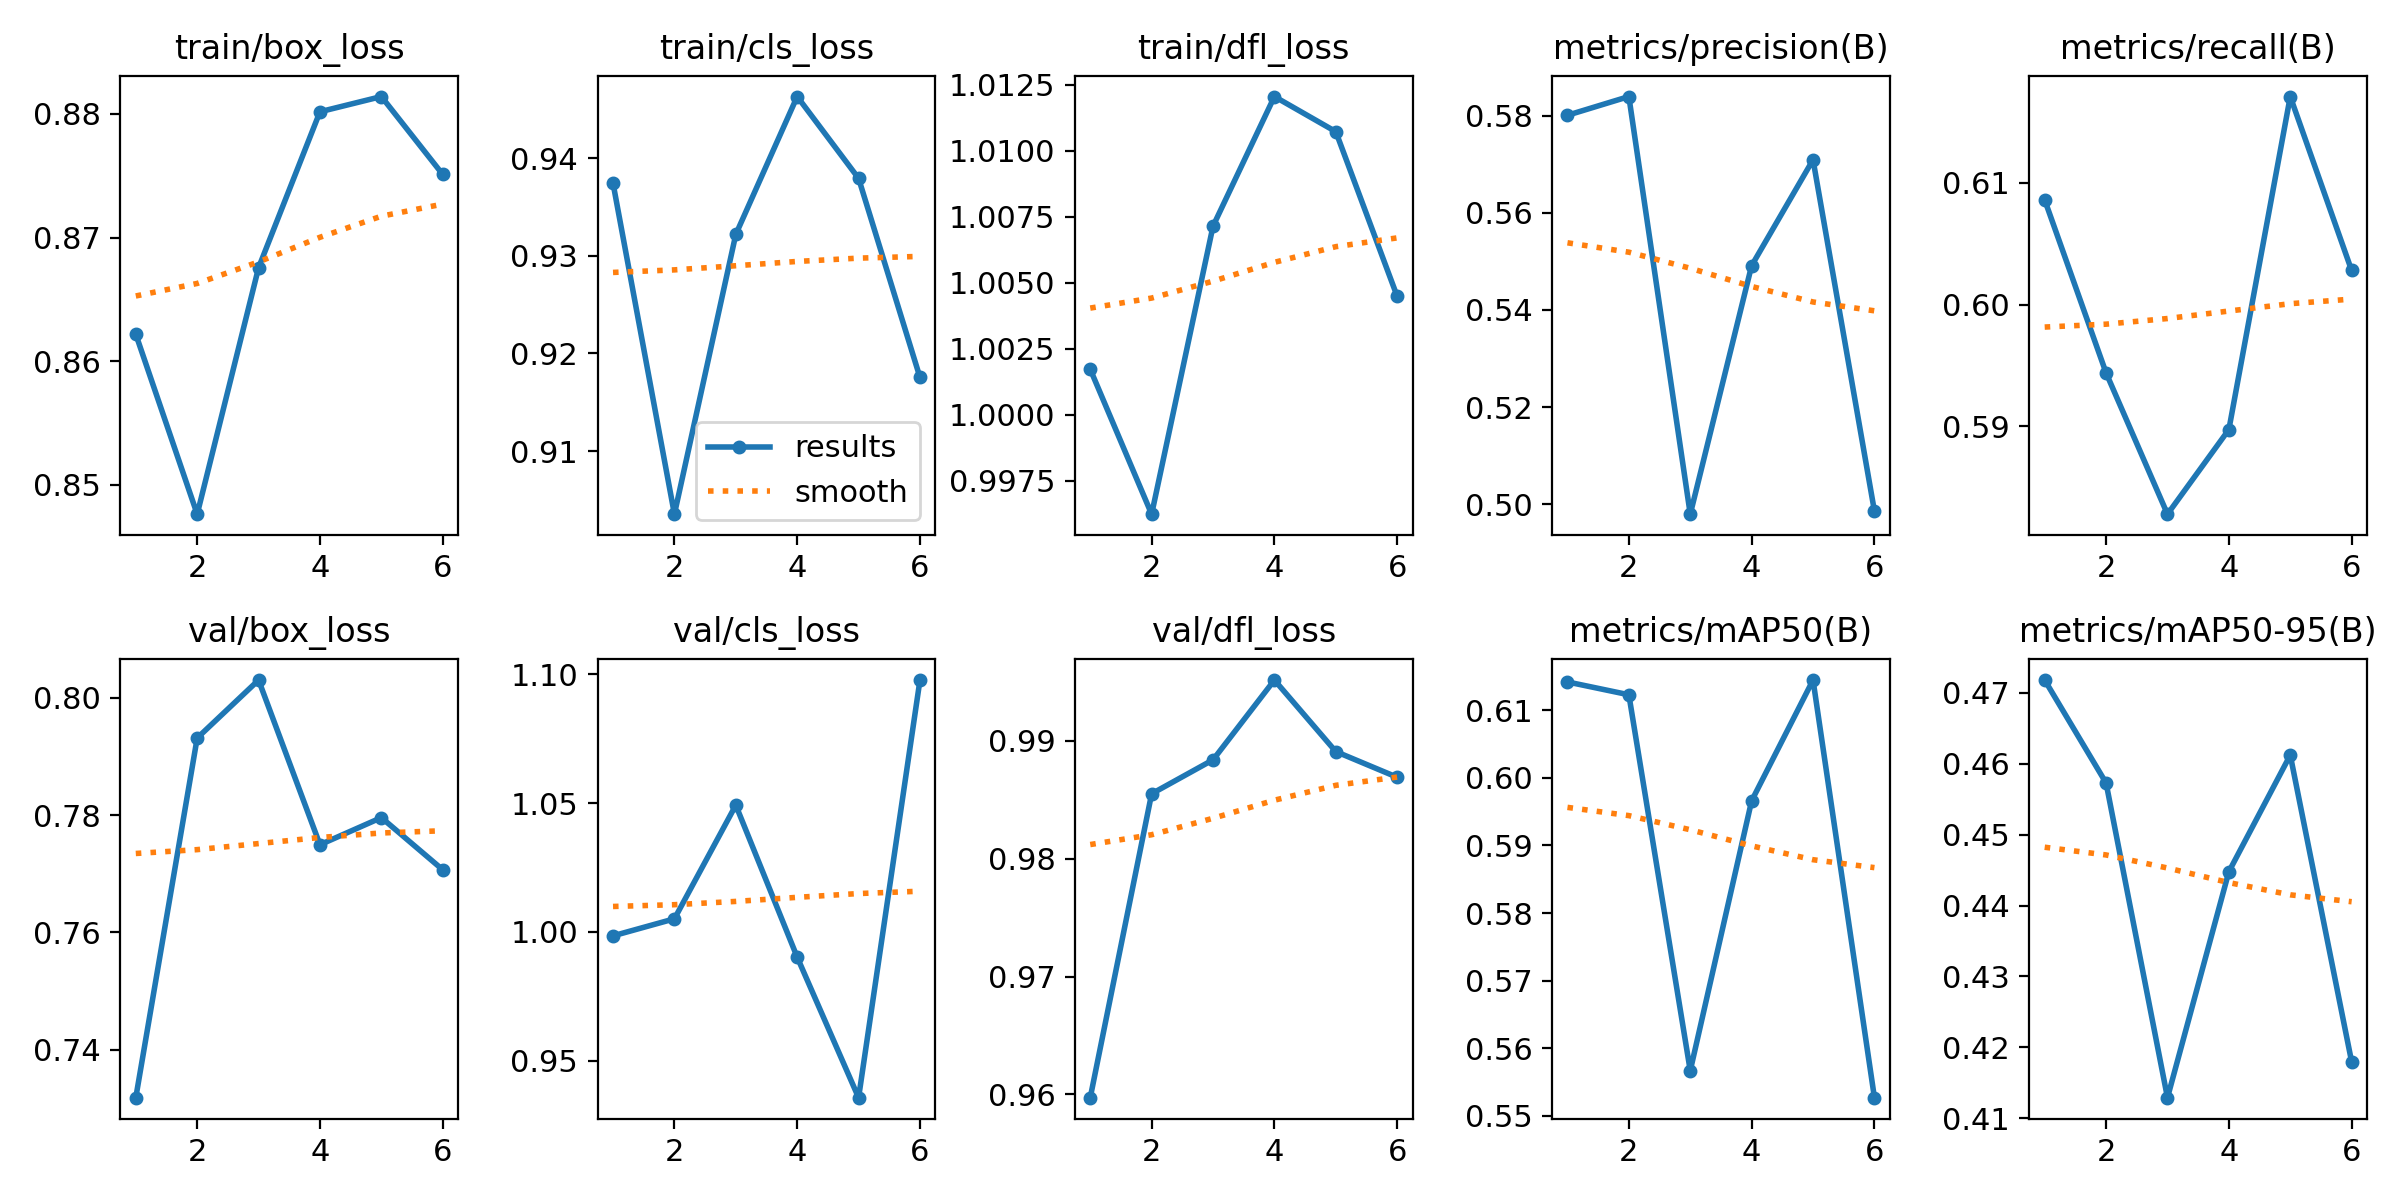

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train3/results.png', width=600)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data